In [1]:
import pandas as pd 
import matplotlib.pyplot as plt 
%matplotlib inline

In [2]:
df_offers = pd.read_excel('WineKMC.xlsx',sheetname=0)

In [3]:
df_offers.head()

,Offer #,Campaign,Varietal,Minimum Qty (kg),Discount (%),Origin,Past Peak
0,1,January,Malbec,72,56,France,False
1,2,January,Pinot Noir,72,17,France,False
2,3,February,Espumante,144,32,Oregon,True
3,4,February,Champagne,72,48,France,True
4,5,February,Cabernet Sauvignon,144,44,New Zealand,True


In [4]:
df_offers.columns = ["offer_id", "campaign", "varietal", "min_qty", "discount", "origin", "past_peak"]

In [5]:
df_offers.head()

,offer_id,campaign,varietal,min_qty,discount,origin,past_peak
0,1,January,Malbec,72,56,France,False
1,2,January,Pinot Noir,72,17,France,False
2,3,February,Espumante,144,32,Oregon,True
3,4,February,Champagne,72,48,France,True
4,5,February,Cabernet Sauvignon,144,44,New Zealand,True


In [6]:
df_transactions = pd.read_excel('WineKMC.xlsx', sheetname=1)

In [7]:
df_transactions.head()

,Customer Last Name,Offer #
0,Smith,2
1,Smith,24
2,Johnson,17
3,Johnson,24
4,Johnson,26


In [8]:
df_transactions.columns = ['customer_name', 'offer_id']
df_transactions['n'] = 1
df_transactions.head()

,customer_name,offer_id,n
0,Smith,2,1
1,Smith,24,1
2,Johnson,17,1
3,Johnson,24,1
4,Johnson,26,1


# let's Begin

I'm trying to learn more about how customers behave, we can use their behavior (whether or not they purchased something based on an offer) as a way to group similar minded customers together. We can then study those groups to look for patterns and trends which can help us formulate future offers.

The first thing we need is a way to compare customers. To do this, we're going to create a matrix that contains each customer and a 0/1 indicator for whether or not they responded to a given offer

In [9]:
df = pd.merge(df_offers, df_transactions)

In [10]:
matrix = df.pivot_table(index=['customer_name'], columns=['offer_id'], values='n')

In [11]:
matrix.head()

offer_id,1,2,3,4,5,6,7,8,9,10,...,23,24,25,26,27,28,29,30,31,32
customer_name,,,,,,,,,,,,,,,,,,,,,
Adams,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,1,1,NaN,NaN
Allen,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,NaN,...,NaN,NaN,NaN,NaN,1,NaN,NaN,NaN,NaN,NaN
Anderson,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,1,NaN,1,NaN,NaN,NaN,NaN,NaN,NaN
Bailey,NaN,NaN,NaN,NaN,NaN,NaN,1,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,NaN,NaN
Baker,NaN,NaN,NaN,NaN,NaN,NaN,1,NaN,NaN,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,NaN


In [12]:
matrix = matrix.fillna(0).reset_index()

In [13]:
matrix.columns[1]

1

In [14]:
x_cols = matrix.columns[1:]

In [15]:
x_cols.shape

(32,)

I have tried many  clustering algorithms but Kmeans and Hierarchical clustering worked the best

In [16]:
from sklearn.cluster import KMeans, MeanShift, SpectralClustering, AgglomerativeClustering

In [18]:
clf = KMeans(n_clusters=5)

In [20]:
matrix['cluster'] = clf.fit_predict(matrix[matrix.columns[2:]])

In [21]:
matrix.cluster.shape

(100,)

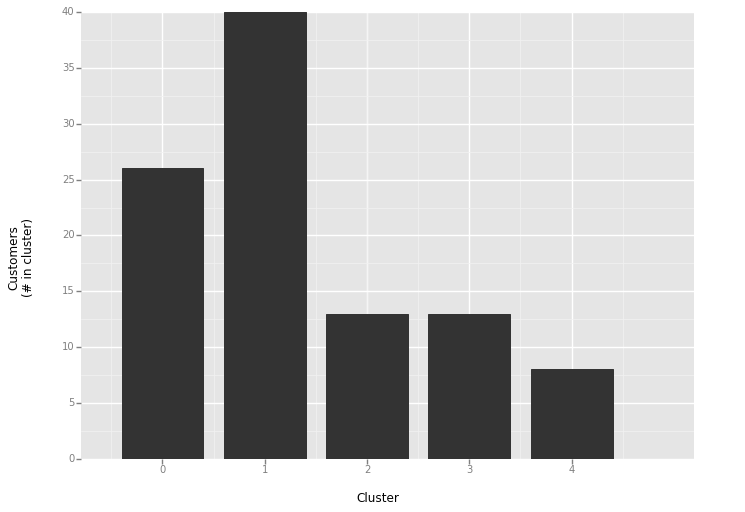

<ggplot: (-9223372036573113028)>

In [22]:
from ggplot import *
ggplot(matrix, aes(x='factor(cluster)')) + geom_bar() + xlab("Cluster") + ylab("Customers\n(# in cluster)")


Then I'm going to perform Principal Component Analysison my data. There are lots of uses for it, but today we're going to use it to transform our multi-dimensional dataset into a 2 dimensional dataset. once it is in 2 dimensions (or simply put, it has 2 columns), it becomes much easier to plot!

In [23]:
from sklearn.decomposition import PCA

In [24]:
pca = PCA(n_components=2)

In [25]:
x_cols.shape

(32,)

In [26]:
matrix['x'] = pca.fit_transform(matrix[x_cols])[:,0]
matrix['y'] = pca.fit_transform(matrix[x_cols])[:,1]

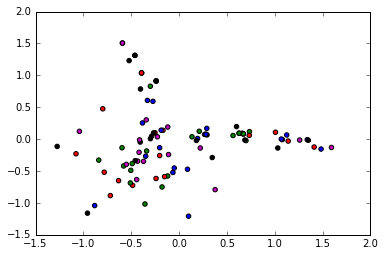

In [27]:
plt.scatter(  matrix['x'], matrix['y'], c = ('r', 'k', 'm', 'g', 'b'))

In [28]:
matrix = matrix.reset_index()

In [29]:
customer_clusters = matrix[['customer_name', 'cluster', 'x', 'y']]

In [30]:
customer_clusters.head()

offer_id,customer_name,cluster,x,y
0,Adams,0,1.007580,0.108215
1,Allen,1,-0.287539,0.044715
2,Anderson,2,-0.392032,1.038391
3,Bailey,0,0.699477,-0.022542
4,Baker,1,0.088183,-0.471695


What we've done is we've taken those x_cols columns of 0/1 indicator variables, and we've transformed them into a 2-D dataset. We took one column and arbitrarily called it x and then called the other y. Now we can throw each point into a scatterplot. We'll color code each point based on it's cluster so it's easier to see them.

In [31]:
df = pd.merge(df_transactions, customer_clusters)

df = pd.merge(df_offers, df)

For a better view GGplot comes to the rescue

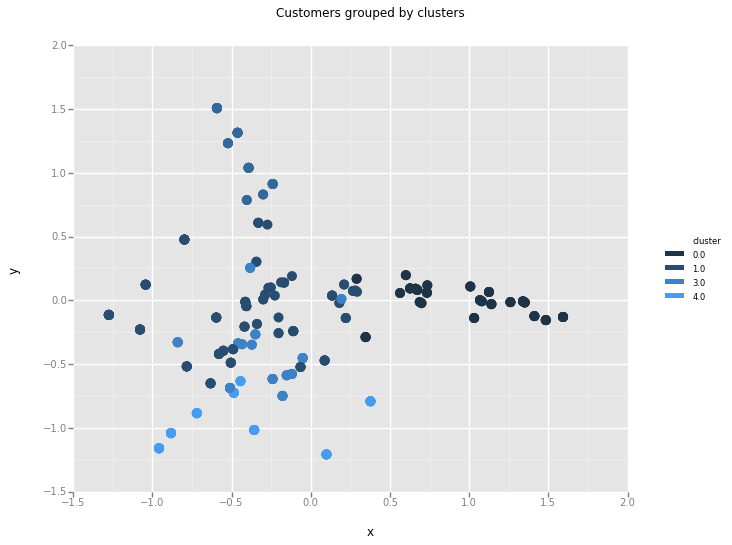

<ggplot: (283258358)>

In [32]:
ggplot(df, aes(x='x', y='y', color = 'cluster'))+geom_point(size = 100)+ggtitle('Customers grouped by clusters')

In [34]:
cluster_centers = pca.fit_transform(clf.cluster_centers_)

In [52]:
cluster_centers = pd.DataFrame(cluster_centers, columns=['x', 'y'])
cluster_centers['cluster'] = range(0, len(cluster_centers))

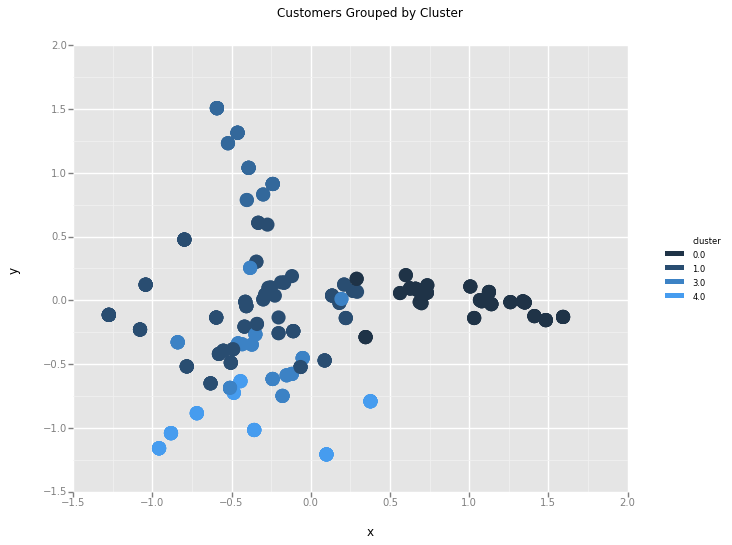

<ggplot: (-9223372036572066935)>

In [53]:
ggplot(df, aes(x='x', y='y', color='cluster')) + \
    geom_point(size=75) + \
    geom_point(cluster_centers, size=200) +\
    ggtitle("Customers Grouped by Cluster")

# Digging deeper into the clusters


Let's dig a little deeper into the clusters. Take cluster 4 for example. If we break out cluster 4 and compare it to the remaining customers, we can start to look for interesting facets that we might be able to exploit.

As a baseline, take a look at the varietal counts for cluster 4 vs. everyone else. It turns out that almost all of the Cabernet Sauvignon offers were purchased by members of cluster 4. In addition, none of the Espumante offers were purchased by members of cluster 4.

In [55]:
df['is_4'] = df.cluster==4
df.groupby("is_4").varietal.value_counts()


is_4   varietal          
False  Champagne             60
       Pinot Noir            44
       Espumante             35
       Malbec                32
       Prosecco              32
       Cabernet Sauvignon    29
       Merlot                19
       Pinot Grigio          17
       Chardonnay            13
True   Champagne             21
       Prosecco              11
       Espumante              5
       Cabernet Sauvignon     3
       Chardonnay             2
       Merlot                 1
dtype: int64

In [56]:
df.groupby("is_4")[['min_qty', 'discount']].mean()

,min_qty,discount
is_4,,
False,55.238434,59.33452
True,79.116279,60.44186


You can also segment out numerical features. For instance, look at how the mean of the min_qty field breaks out between 4 vs. non-4. It seems like members of cluster 4 like to by in bulk!